In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [ ]:
import json

# Loading data

In [3]:
FILEPATH = "../data/result.json"

In [4]:
with open(FILEPATH, 'r') as f:
        data = json.load(f)

# Graph Louvain study

In [ ]:
from graph import build_graph_with_external_nodes
import networkx as nx
import community as community_louvain

In [5]:
G = build_graph_with_external_nodes(data)

Adding 504 internal nodes...
Processing edges and adding external nodes...
Added 719 external nodes.
Graph built successfully: 1223 total nodes, 2046 edges.


In [8]:
labels_louvain_dict = {}

G_undirected = G.to_undirected()
# G_undirected.remove_nodes_from(list(nx.isolates(G_undirected)))

partition = community_louvain.best_partition(G_undirected)
labels_louvain_dict = partition

print(f"Louvain found {len(set(partition.values()))} communities.")

Louvain found 28 communities.


In [12]:
from collections import Counter

Counter(partition.values())

Counter({0: 239,
         10: 96,
         9: 87,
         13: 77,
         15: 59,
         25: 59,
         21: 55,
         4: 54,
         2: 53,
         23: 53,
         18: 52,
         20: 50,
         8: 40,
         6: 33,
         22: 33,
         11: 31,
         16: 29,
         26: 22,
         1: 22,
         3: 21,
         7: 20,
         19: 13,
         14: 6,
         17: 6,
         24: 6,
         27: 3,
         12: 3,
         5: 1})

# Clustring using embedding

## DBSCAN

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

In [16]:
labels_sklearn = None
internal_node_list = []
embedding_list = []

for node, data in G.nodes(data=True):
    if data.get('is_internal', False):
        embedding = data.get('embedding')
        if embedding is not None and (isinstance(embedding, np.ndarray) or isinstance(embedding, list)):
            internal_node_list.append(node)
            embedding_list.append(embedding)

X_embeddings = np.array(embedding_list)

# plus pour KMeans mais ça coute rien
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_embeddings)

X_scaled.shape

(503, 768)

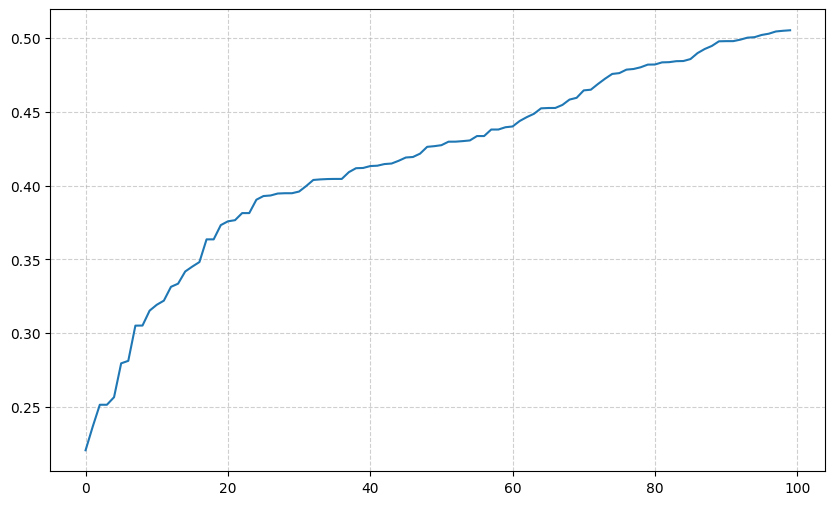

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

k=5

neighbors = NearestNeighbors(n_neighbors=k, metric='cosine')
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

kth_distances = distances[:, k-1]
sorted_distances = np.sort(kth_distances)

plt.figure(figsize=(10, 6))
plt.plot(range(100), sorted_distances[:100])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [43]:
dbscan_eps = 0.1
dbscan_min_samples = 5 

dbscan_clusterer = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples, metric='cosine') 
labels_sklearn = dbscan_clusterer.fit_predict(X_embeddings) # Use X_scaled if scaling was applied

n_clusters_sklearn = len(set(labels_sklearn)) - (1 if -1 in labels_sklearn else 0)
n_noise = np.sum(labels_sklearn == -1)
print(f"DBSCAN Found {n_clusters_sklearn} clusters.")


DBSCAN Found 5 clusters.


Not relevant testing an other method

# KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

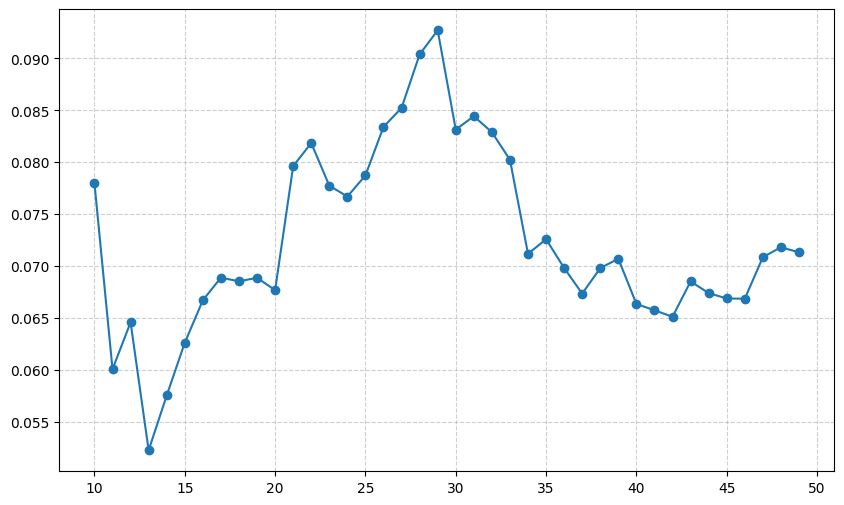

In [53]:
k_range = range(10, 50) 
silhouette_avg_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=411)
    cluster_labels = kmeans.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X_scaled, cluster_labels, metric='cosine')
    silhouette_avg_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_avg_scores, marker='o', linestyle='-')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [54]:
kmeans_k = 28 # Louvain 28 / Sohouette 29

kmeans_clusterer = KMeans(n_clusters=kmeans_k, n_init='auto', random_state=42) # random_state for reproducibility
labels_sklearn = kmeans_clusterer.fit_predict(X_scaled) # Use X_scaled if scaling was applied

n_clusters_sklearn = len(set(labels_sklearn)) # Should equal kmeans_k
print(f"KMeans Assigned nodes to {n_clusters_sklearn} clusters.")


KMeans Assigned nodes to 28 clusters.


## Consolidating

In [ ]:

# Example of how the comparison section would adapt:
# (Assuming labels_louvain_aligned exists and is valid)
# print("3. Comparing Clustering Results...")
# if labels_sklearn is not None and labels_louvain_aligned:
#     try:
#         # Filter out noise points (-1 from DBSCAN/HDBSCAN) and missing Louvain nodes (-99)
#         # For KMeans, noise filtering is not applicable unless you implement a threshold.
#         is_noise = (lambda l: l == -1) if isinstance(dbscan_clusterer, DBSCAN) else (lambda l: False) # Adapt if using KMeans
#
#         common_indices = [i for i, (l_l, l_s) in enumerate(zip(labels_louvain_aligned, labels_sklearn)) if l_l != -99 and not is_noise(l_s)]
#         if common_indices:
#             filtered_louvain = [labels_louvain_aligned[i] for i in common_indices]
#             filtered_sklearn = [labels_sklearn[i] for i in common_indices]
#
#             ari = adjusted_rand_score(filtered_louvain, filtered_sklearn)
#             nmi = normalized_mutual_info_score(filtered_louvain, filtered_sklearn)
#             print(f"   Comparison Metrics (on {len(common_indices)} non-noise/valid nodes):")
#             print(f"     Adjusted Rand Index (ARI): {ari:.4f}")
#             print(f"     Normalized Mutual Info (NMI): {nmi:.4f}")
#         else:
#             print("   Could not compare - no common non-noise nodes.")
#     except Exception as e:
#         print(f"   Error calculating comparison metrics: {e}")
# else:
#     print("   Skipping comparison due to errors in clustering steps.")

In [ ]:

import numpy as np
import pandas as pd
import datetime
import time
import torch
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx


# --- Stage 1: Exploration (Separate Clustering + Comparison) ---
def perform_exploratory_clustering(G, embedding_field='embedding', min_cluster_size_hdbscan=10):
    """
    Performs Louvain on structure and HDBSCAN on embeddings, then compares.

    Args:
        G (nx.DiGraph): Graph with node attributes including embeddings.
        embedding_field (str): Name of the node attribute holding embeddings.
        min_cluster_size_hdbscan (int): Parameter for HDBSCAN.

    Returns:
        tuple: (internal_node_list, labels_louvain, labels_hdbscan)
               Returns None for labels if clustering fails.
    """
    print("\n--- Stage 1: Exploratory Clustering ---")



    

    # --- Align Louvain labels ---
    # Ensure Louvain labels correspond to the same internal_node_list order
    labels_louvain_aligned = []
    louvain_success = True
    try:
        labels_louvain_aligned = [labels_louvain_dict.get(node, -99) for node in internal_node_list] # Use -99 for nodes missing from Louvain
        if -99 in labels_louvain_aligned:
             print("   Warning: Some internal nodes were missing from Louvain results.")
    except Exception as e:
        print(f"   Error aligning Louvain labels: {e}")
        louvain_success = False


    # --- Comparison ---
    print("3. Comparing Clustering Results...")
    if labels_hdbscan is not None and labels_louvain_aligned and louvain_success:
        try:
            # Filter out noise points (-1 from HDBSCAN) and missing Louvain nodes (-99) for comparison
            common_indices = [i for i, (l_l, l_h) in enumerate(zip(labels_louvain_aligned, labels_hdbscan)) if l_l != -99 and l_h != -1]
            if common_indices:
                filtered_louvain = [labels_louvain_aligned[i] for i in common_indices]
                filtered_hdbscan = [labels_hdbscan[i] for i in common_indices]

                ari = adjusted_rand_score(filtered_louvain, filtered_hdbscan)
                nmi = normalized_mutual_info_score(filtered_louvain, filtered_hdbscan)
                print(f"   Comparison Metrics (on {len(common_indices)} non-noise/valid nodes):")
                print(f"     Adjusted Rand Index (ARI): {ari:.4f}")
                print(f"     Normalized Mutual Info (NMI): {nmi:.4f}")
                print("     (Scores closer to 1 indicate higher similarity between clusterings)")
            else:
                 print("   Could not compare - no common non-noise nodes.")

        except Exception as e:
            print(f"   Error calculating comparison metrics: {e}")
    else:
        print("   Skipping comparison due to errors in clustering steps.")

    print("   Manual inspection of clusters is highly recommended.")

    return internal_node_list, labels_louvain_aligned if louvain_success else None, labels_hdbscan


# --- GNN Model Definition (Graph Autoencoder with GCN layers) ---
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels) # out_channels = embedding dimension

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# --- Stage 2: GNN + Vector Clustering ---
def perform_gnn_clustering(G, embedding_field='embedding', gnn_embedding_dim=64, epochs=100, lr=0.01, min_cluster_size_hdbscan=10):
    """
    Trains a GAE model, extracts structure-aware embeddings, and clusters them.

    Args:
        G (nx.DiGraph): Graph with node attributes including *initial* embeddings.
        embedding_field (str): Name of the node attribute holding initial embeddings.
        gnn_embedding_dim (int): Dimension of the learned GNN embeddings.
        epochs (int): Number of training epochs for the GNN.
        lr (float): Learning rate for the GNN optimizer.
        min_cluster_size_hdbscan (int): Parameter for final HDBSCAN.

    Returns:
        tuple: (internal_node_list, final_gnn_embeddings, labels_gnn_hdbscan)
               Returns None for labels/embeddings if process fails.
    """
    print("\n--- Stage 2: GNN-based Clustering ---")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # --- 1. Prepare Data for PyTorch Geometric ---
    print("1. Preparing data for PyTorch Geometric...")
    try:
        # Create mapping from node URL to integer index
        node_list = list(G.nodes())
        node_map = {node: i for i, node in enumerate(node_list)}

        # Create node feature matrix 'x'
        num_nodes = G.number_of_nodes()
        # Determine input feature dimension from the first valid embedding
        input_embedding_dim = None
        for node in node_list:
            emb = G.nodes[node].get(embedding_field)
            if emb is not None:
                input_embedding_dim = len(emb)
                break
        if input_embedding_dim is None:
            print("   Error: Could not determine input embedding dimension. Ensure embeddings are added.")
            return None, None, None

        x = torch.zeros((num_nodes, input_embedding_dim), dtype=torch.float)
        internal_node_indices = []
        for i, node in enumerate(node_list):
            if G.nodes[node].get('is_internal', False):
                emb = G.nodes[node].get(embedding_field)
                if emb is not None:
                    x[i] = torch.tensor(emb, dtype=torch.float)
                    internal_node_indices.append(i)
            # External nodes remain as zero vectors (or use random init if preferred)

        # Create edge index tensor
        # Need to map URLs in edges to integer indices
        adj = nx.to_scipy_sparse_array(G).tocoo() # Use SciPy sparse format
        row = torch.from_numpy(adj.row.astype(np.int64))
        col = torch.from_numpy(adj.col.astype(np.int64))
        edge_index = torch.stack([row, col], dim=0)

        # Create PyG Data object
        data_pyg = Data(x=x, edge_index=edge_index).to(device)
        print(f"   PyG Data object created: Nodes={data_pyg.num_nodes}, Edges={data_pyg.num_edges}, Features={data_pyg.num_node_features}")

    except Exception as e:
        print(f"   Error preparing data for PyG: {e}")
        return None, None, None

    # --- 2. Define and Train GNN Model (GAE) ---
    print(f"2. Defining and Training Graph Autoencoder (GAE) for {epochs} epochs...")
    try:
        model = GAE(GCNEncoder(input_embedding_dim, 2 * gnn_embedding_dim, gnn_embedding_dim)).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        model.train()
        start_train_time = time.time()
        for epoch in range(1, epochs + 1):
            optimizer.zero_grad()
            z = model.encode(data_pyg.x, data_pyg.edge_index)
            loss = model.recon_loss(z, data_pyg.edge_index) # Use positive edges for reconstruction
            # Optional: Add negative sampling for more robust training
            # neg_edge_index = ... (generate negative edges)
            # loss = model.recon_loss(z, data_pyg.edge_index, neg_edge_index)
            loss.backward()
            optimizer.step()
            if epoch % 10 == 0 or epoch == 1:
                print(f'   Epoch: {epoch:03d}, Loss: {loss:.4f}')
        train_duration = time.time() - start_train_time
        print(f"   GNN Training finished in {train_duration:.2f} seconds.")

    except Exception as e:
        print(f"   Error during GNN training: {e}")
        return None, None, None

    # --- 3. Extract Learned Embeddings ---
    print("3. Extracting learned structure-aware embeddings...")
    try:
        model.eval()
        with torch.no_grad():
            final_z = model.encode(data_pyg.x, data_pyg.edge_index)
        final_embeddings_all_nodes = final_z.cpu().numpy()

        # Extract embeddings only for the original internal nodes
        internal_node_urls = [node for node, data in G.nodes(data=True) if data.get('is_internal')]
        internal_indices_in_map = [node_map[url] for url in internal_node_urls]
        final_embeddings_internal = final_embeddings_all_nodes[internal_indices_in_map]
        print(f"   Extracted embeddings for {len(internal_node_urls)} internal nodes. Shape: {final_embeddings_internal.shape}")

    except Exception as e:
        print(f"   Error extracting GNN embeddings: {e}")
        return None, None, None


    # --- 4. Cluster Learned Embeddings ---
    print("4. Clustering learned GNN embeddings using HDBSCAN...")
    labels_gnn_hdbscan = None
    try:
        # Scale GNN embeddings before clustering? Sometimes helpful.
        # scaler_gnn = StandardScaler()
        # final_embeddings_scaled = scaler_gnn.fit_transform(final_embeddings_internal)
        # clusterer_gnn = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size_hdbscan).fit(final_embeddings_scaled)

        clusterer_gnn = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size_hdbscan,
            metric='euclidean' # GNN embeddings often work well with Euclidean
            )
        labels_gnn_hdbscan = clusterer_gnn.fit_predict(final_embeddings_internal)
        n_clusters_gnn = len(set(labels_gnn_hdbscan)) - (1 if -1 in labels_gnn_hdbscan else 0)
        noise_points_gnn = np.sum(labels_gnn_hdbscan == -1)
        print(f"   HDBSCAN on GNN embeddings found {n_clusters_gnn} clusters with {noise_points_gnn} noise points.")

    except Exception as e:
        print(f"   Error during HDBSCAN clustering on GNN embeddings: {e}")
        # Return embeddings even if clustering fails
        return internal_node_urls, final_embeddings_internal, None

    return internal_node_urls, final_embeddings_internal, labels_gnn_hdbscan


# --- Main Execution Logic ---
if __name__ == "__main__":
    # Use location and time context
    current_time = datetime.datetime.now(datetime.timezone.utc).astimezone()
    location = "Noisy-le-Grand, Île-de-France, France"
    print(f"Executing clustering script at {current_time.strftime('%Y-%m-%d %H:%M:%S %Z')} from {location}")


    # --- Load your data ---
    print("\nLoading data (replace with your actual data loading)...")
    # Assume 'data' is your dictionary with URLs as keys and values like:
    # {'description': ..., 'texte': ..., 'liens': [...], 'embedding': [vector]}
    # For demonstration, using a placeholder structure
    data = {
        f"https://site.com/page{i}": {
            'description': f'Desc {i}',
            'texte': f'Contenu textuel page {i}. Mentionne sujet {(i % 5)}.',
            'liens': [f"https://site.com/page{(i+1)%10}", f"https://site.com/page{(i+2)%10}", f"https://ext.com/{i}"],
            # Simulate embeddings (replace with your actual embeddings)
            'embedding': np.random.rand(768) # Example dimension
        } for i in range(50) # Use a smaller number for quick testing, replace 50 with 5000 for your case
    }
    print(f"Loaded data for {len(data)} pages.")


    # --- Build Graph and Add Embeddings ---
    G = build_graph_with_external_nodes(data)
    G = add_embeddings_to_graph(G, data, embedding_field='embedding') # Ensure embeddings are in the graph


    # --- Run Stage 1 ---
    stage1_results = perform_exploratory_clustering(G, embedding_field='embedding', min_cluster_size_hdbscan=5) # Adjust min_cluster_size
    # stage1_results contains: (internal_node_list, labels_louvain, labels_hdbscan)


    # --- Run Stage 2 ---
    # Adjust parameters as needed (embedding dim, epochs, lr, min cluster size)
    gnn_nodes, gnn_embeddings, gnn_labels = perform_gnn_clustering(
        G,
        embedding_field='embedding',
        gnn_embedding_dim=64,
        epochs=50, # Start with fewer epochs for testing
        lr=0.01,
        min_cluster_size_hdbscan=5 # Adjust based on expected cluster density
    )

    # --- Further Analysis ---
    print("\n--- Further Analysis Ideas ---")
    if stage1_results and stage1_results[0] and gnn_labels is not None:
         # Ensure the node lists match if comparing directly
         if gnn_nodes == stage1_results[0]:
             print("Comparing Stage 1 (Louvain/HDBSCAN) vs Stage 2 (GNN+HDBSCAN)...")
             if stage1_results[1] is not None:
                 # Compare Louvain vs GNN+HDBSCAN
                 valid_indices_l = [i for i, l in enumerate(stage1_results[1]) if l != -99 and gnn_labels[i] != -1]
                 if valid_indices_l:
                     ari_l_gnn = adjusted_rand_score([stage1_results[1][i] for i in valid_indices_l], [gnn_labels[i] for i in valid_indices_l])
                     nmi_l_gnn = normalized_mutual_info_score([stage1_results[1][i] for i in valid_indices_l], [gnn_labels[i] for i in valid_indices_l])
                     print(f"  Louvain vs GNN+HDBSCAN (ARI): {ari_l_gnn:.4f}")
                     print(f"  Louvain vs GNN+HDBSCAN (NMI): {nmi_l_gnn:.4f}")

             if stage1_results[2] is not None:
                 # Compare Content-HDBSCAN vs GNN+HDBSCAN
                 valid_indices_h = [i for i, l in enumerate(stage1_results[2]) if l != -1 and gnn_labels[i] != -1]
                 if valid_indices_h:
                     ari_h_gnn = adjusted_rand_score([stage1_results[2][i] for i in valid_indices_h], [gnn_labels[i] for i in valid_indices_h])
                     nmi_h_gnn = normalized_mutual_info_score([stage1_results[2][i] for i in valid_indices_h], [gnn_labels[i] for i in valid_indices_h])
                     print(f"  Content-HDBSCAN vs GNN+HDBSCAN (ARI): {ari_h_gnn:.4f}")
                     print(f"  Content-HDBSCAN vs GNN+HDBSCAN (NMI): {nmi_h_gnn:.4f}")

         else:
              print("Node order mismatch, cannot directly compare Stage 1 and Stage 2 labels.")

    # You can now analyze the 'gnn_labels' dictionary which holds the final cluster assignments
    # for your internal nodes based on the GNN approach.
    if gnn_labels is not None:
        print("\nExample: Displaying GNN cluster assignments for first 20 internal nodes:")
        results_df = pd.DataFrame({'Node': gnn_nodes, 'GNN_Cluster': gnn_labels})
        print(results_df.head(20))
        # Analyze cluster sizes
        print("\nGNN Cluster Sizes (excluding noise -1):")
        print(results_df[results_df['GNN_Cluster'] != -1]['GNN_Cluster'].value_counts())